- 진행계획
    - FCN 방식을 통해서 스펙트로그램의 어떤 부분이 그 단어를 의미하는지 표시하는 것에 집중
    - 일단 label이 bed 인것만 끄집어내서 진행

In [1]:
import torch.nn as nn


# 1. Model Structure

In [2]:
# https://github.com/wkentaro/pytorch-fcn/blob/master/torchfcn/models/fcn32s.py <- 여기서 들고옴
# https://github.com/shelhamer/fcn.berkeleyvision.org/blob/master/surgery.py <- 이건 윗사람이 들고온곳인듯

def get_upsampling_weight(in_channels, out_channels, kernel_size):
    """Make a 2D bilinear kernel suitable for upsampling"""
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    filt = (1 - abs(og[0] - center) / factor) * \
           (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                      dtype=np.float64)
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight).float()


class FCN8s(nn.Module):
    def __init__(self, n_class=2):
        super(FCN8s, self).__init__()
        # conv1
        self.conv1_1 = nn.Conv2d(1, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/2

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/4

        # conv3
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/8

        # conv4
        self.conv4_1 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/16

        # conv5
        self.conv5_1 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)  # 1/32

        # fc6
        self.fc6 = nn.Conv2d(256, 1024, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d()

        # fc7
        self.fc7 = nn.Conv2d(1024, 1024, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d()

        self.score_fr = nn.Conv2d(1024, n_class, 1)
        self.score_pool3 = nn.Conv2d(256, n_class, 1)
        self.score_pool4 = nn.Conv2d(256, n_class, 1)

        self.upscore2 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)
        self.upscore8 = nn.ConvTranspose2d(
            n_class, n_class, 16, stride=8, bias=False)
        self.upscore_pool4 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, bias=False)

        self._initialize_weights()
        
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        h = x
        h = self.relu1_1(self.conv1_1(h))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)
        pool3 = h  # 1/8

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)
        pool4 = h  # 1/16

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.relu6(self.fc6(h))
        h = self.drop6(h)

        h = self.relu7(self.fc7(h))
        h = self.drop7(h)

        h = self.score_fr(h)
        h = self.upscore2(h)
        upscore2 = h  # 1/16

        h = self.score_pool4(pool4)
        h = h[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        score_pool4c = h  # 1/16

        h = upscore2 + score_pool4c  # 1/16
        h = self.upscore_pool4(h)
        upscore_pool4 = h  # 1/8

        h = self.score_pool3(pool3)
        h = h[:, :,
              9:9 + upscore_pool4.size()[2],
              9:9 + upscore_pool4.size()[3]]
        score_pool3c = h  # 1/8

        h = upscore_pool4 + score_pool3c  # 1/8

        h = self.upscore8(h)
        h = h[:, :, 31:31 + x.size()[2], 31:31 + x.size()[3]].contiguous()

        return h

# 2. Trainer

- loss function

In [3]:
import datetime
from distutils.version import LooseVersion
import math
import os
import os.path as osp
import shutil

import numpy as np
#import skimage.io
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import tqdm 
import sys
#import torchfcn

In [4]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    # input: (n, c, h, w), 
    # target: (n, h, w), 0~n_class number
    n, c, h, w = input.size()
    # log_p: (n, c, h, w)
    if LooseVersion(torch.__version__) < LooseVersion('0.3'):
        # ==0.2.X
        log_p = F.log_softmax(input)
    else:
        # >=0.3
        log_p = F.log_softmax(input, dim=1)
    # log_p: (n*h*w, c)
    log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous()

    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0] 
    # target: (n*h*w,)
    mask = target >= 0
    target = target[mask]
    loss = F.nll_loss(log_p.view(-1, c), target.view(-1), weight=weight, reduction='sum') # The negative log likelihood loss.
    if size_average:
        loss /= mask.data.sum()
    return loss

# utils for validation
def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * np.int32(label_true[mask]) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)
    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (
            hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist)
        )
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc

In [5]:
class Trainer(object):

    def __init__(self, cuda, model, optimizer,
                 train_loader, val_loader, out, max_iter, n_class, 
                 size_average=False, interval_validate=None):
        self.cuda = cuda

        self.model = model
        self.optim = optimizer

        self.train_loader = train_loader
        self.val_loader = val_loader

        self.timestamp_start = \
            datetime.datetime.now()
        self.size_average = size_average

        if interval_validate is None:
            self.interval_validate = len(self.train_loader)
        else:
            self.interval_validate = interval_validate

        self.out = out
        if not osp.exists(self.out):
            os.makedirs(self.out)

        self.log_headers = [
            'epoch',
            'iteration',
            'train/loss',
            'train/acc',
            'train/acc_cls',
            'train/mean_iu',
            'train/fwavacc',
            'valid/loss',
            'valid/acc',
            'valid/acc_cls',
            'valid/mean_iu',
            'valid/fwavacc',
            'elapsed_time',
        ]
        if not osp.exists(osp.join(self.out, 'log.csv')):
            with open(osp.join(self.out, 'log.csv'), 'w') as f:
                f.write(','.join(self.log_headers) + '\n')

        self.epoch = 0
        self.loss = 0
        self.iteration = 0
        self.max_iter = max_iter
        self.best_mean_iu = 0
        self.n_class = n_class
        
    def validate(self):
        training = self.model.training
        self.model.eval()

        n_class = self.n_class 

        val_loss = 0
        visualizations = []
        label_trues, label_preds = [], []
        for batch_idx, (data, target) in tqdm.notebook.tqdm(
                enumerate(self.val_loader), total=len(self.val_loader),
                desc='Valid iteration=%d' % self.iteration, leave=False):
            if self.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target).to(dtype=torch.long) # target data type 이슈
            with torch.no_grad():
                score = self.model(data)
            loss = cross_entropy2d(score, target,
                                   size_average=self.size_average)
            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while validating')
            val_loss += loss_data / len(data)

            imgs = data.data.cpu()
            lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
            lbl_true = target.data.cpu()
            fig = plt.figure(figsize=(10, 12))
            fig.add_subplot(1, 3, 1)
            plt.imshow(imgs.numpy()[0, 0, :, :])
            fig.add_subplot(1, 3, 2)
            plt.imshow(lbl_pred[0, :, :])
            fig.add_subplot(1, 3, 3)
            plt.imshow(lbl_true.numpy()[0, :, :])
            plt.show()
            for img, lt, lp in zip(imgs, lbl_true, lbl_pred):
                label_trues.append(lt)
                label_preds.append(lp)
            break    
        metrics = label_accuracy_score(
            label_trues, label_preds, n_class)


        val_loss /= len(self.val_loader)

        with open(osp.join(self.out, 'log.csv'), 'a') as f:
            elapsed_time = (
                datetime.datetime.now() -
                self.timestamp_start).total_seconds()
            log = [self.epoch, self.iteration] + [''] * 5 + \
                  [val_loss] + list(metrics) + [elapsed_time]
            log = map(str, log)
            f.write(','.join(log) + '\n')

        mean_iu = metrics[2]
        is_best = mean_iu > self.best_mean_iu
        if is_best:
            self.best_mean_iu = mean_iu
        torch.save({
            'epoch': self.epoch,
            'iteration': self.iteration,
            'arch': self.model.__class__.__name__,
            'optim_state_dict': self.optim.state_dict(),
            'model_state_dict': self.model.state_dict(),
            'best_mean_iu': self.best_mean_iu,
        }, osp.join(self.out, 'checkpoint.pth.tar'))
        if is_best:
            shutil.copy(osp.join(self.out, 'checkpoint.pth.tar'),
                        osp.join(self.out, 'model_best.pth.tar'))

        if training:
            self.model.train()

    def train_epoch(self):
        self.model.train()
        
        n_class = self.n_class
            # for jupyter notebook (tqdm.notebook.tqdm)
        for batch_idx, (data, target) in tqdm.notebook.tqdm(
                enumerate(self.train_loader), total=len(self.train_loader),
                desc='Train epoch={}'.format(self.epoch), leave=False):
            iteration = batch_idx + self.epoch * len(self.train_loader)
            if self.iteration != 0 and (iteration - 1) != self.iteration:
                continue  # for resuming
            self.iteration = iteration
        
            if self.iteration % self.interval_validate == 0:
                self.validate()

            #assert self.model.training

            if self.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target).to(dtype=torch.long) # target data type 이슈
            self.optim.zero_grad()
            score = self.model(data)
            
            loss = cross_entropy2d(score, target,
                                   size_average=self.size_average)
            loss /= len(data)
            loss_data = loss.data.item()
            sys.stdout.write('\r iteration : {0}, loss : {1:>20s}'.format(iteration, str(np.round(loss_data, decimals=4))))
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
            loss.backward()
            self.optim.step()

            metrics = []
            lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
            lbl_true = target.data.cpu().numpy()
            acc, acc_cls, mean_iu, fwavacc = \
                label_accuracy_score(
                    lbl_true, lbl_pred, n_class=n_class)
            metrics.append((acc, acc_cls, mean_iu, fwavacc))
            metrics = np.mean(metrics, axis=0)

            with open(osp.join(self.out, 'log.csv'), 'a') as f:
                elapsed_time = (
                    datetime.datetime.now() -
                    self.timestamp_start).total_seconds()
                log = [self.epoch, self.iteration] + [loss_data] + \
                    metrics.tolist() + [''] * 5 + [elapsed_time]
                log = map(str, log)
                f.write(','.join(log) + '\n')

            if self.iteration >= self.max_iter:
                break

    def train(self):
        max_epoch = int(math.ceil(1. * self.max_iter / len(self.train_loader)))
        

        for epoch in tqdm.notebook.trange(self.epoch, max_epoch,
                                 desc='Train'):
            self.epoch = epoch
            self.train_epoch()
            if self.iteration >= self.max_iter:
                break

# 3. 학습(실행)

## 3.1. args

In [6]:
class DictToObject(object):

    def __init__(self, dictionary):
        def _traverse(key, element):
            if isinstance(element, dict):
                return key, DictToObject(element)
            else:
                return key, element

        objd = dict(_traverse(k, v) for k, v in dictionary.items())
        self.__dict__.update(objd)



In [7]:
config_dict = {
    'gpu': 0, 
    'resume': False,
    
    'max_iteration': 500000,
    'lr': 0.001,
    'weight_decay': 0.0001,
    'momentum': 0.99,
    'batch_size': 10,
    'model': 'fcn8',
    'n_class': 2,
    'interval_validate': 1000,
}
# log diectory 생성
import os
import os.path as osp
#here = osp.dirname(osp.abspath(__file__))
here = osp.dirname('./')

now = datetime.datetime.now()
out = osp.join(here, 'logs', now.strftime('%Y%m%d_%H%M%S.%f'))

os.makedirs(out)
config_dict['out'] = out # log output directory 넣어줌
args = DictToObject(config_dict)

In [8]:
os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
cuda = torch.cuda.is_available()


## 3.1. dataset

In [9]:
from torch.utils.data import Dataset, DataLoader
import torch
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import librosa

from scipy.io import wavfile
import glob
import tqdm


In [10]:
def get_melspectrogram(signal, fs, nfft):
    hop_length = int(fs/nfft)
    n_mles = nfft/2
    mel_result = librosa.feature.melspectrogram(y=np.float32(signal), sr=fs, n_mels=n_mles, hop_length=hop_length) # melspectrogram 
    mel_result_db = librosa.power_to_db(mel_result, ref=np.max) # 데시벨로 데이터 범위 한정 (로그를씌웟나 그랫던거같음)
    
    #print (mel_result_db.shape)
    return mel_result_db

In [11]:
class GetTrainDataset(Dataset):
    # Initialize your data, download, etc. 
    def __init__(self, dir_list): 
        self.dir_list = np.sort(dir_list)
        self.len = self.dir_list.shape[0] 
        label_df = pd.read_csv('./train_answer.csv')
        self.label_bed = np.int32(label_df.bed.values!=0) # label bed 인 부분만 꺼내서 0이 아니면 1로지정
        
        
    def __getitem__(self, index):
        # get item이 호출될 때, directory 에서 파일 로드해서 melspectrogram 연산
        fs, signal = wavfile.read(self.dir_list[index])
        mel_result = get_melspectrogram(signal, fs=fs, nfft=160)
        w, h = mel_result.shape
        # pytorch input shape [channels, height, width]
        self.x_data = torch.from_numpy(mel_result[np.newaxis, :, :])  
        self.y_data = torch.from_numpy(np.tile(self.label_bed[index, np.newaxis, np.newaxis], [1, w, h])[0]) 
        
        return self.x_data, self.y_data # 현재의문사항 앞에 batch_size없어도되나?
    
    def __len__(self):
        return self.len 
    
    # melSpectrogram 을 얻기위한 함수
    def get_melspectrogram(self, signal, fs, nfft):
        hop_length = int(fs/nfft)
        n_mles = nfft/2
        mel_result = librosa.feature.melspectrogram(y=np.float32(signal), sr=fs, n_mels=n_mles, hop_length=hop_length) # melspectrogram 
        mel_result_db = librosa.power_to_db(mel_result, ref=np.max) # 데시벨로 데이터 범위 한정 (로그를씌웟나 그랫던거같음)

        #print (mel_result_db.shape)
        return mel_result_db
    
    

In [12]:
print (len(glob.glob('./train/*.wav')))

100000


In [13]:
# 앞에서 9만번까지는 train 그 다음은 valid로 사용
train_dir_list = np.sort(glob.glob('./train/*.wav'))[:90000]
valid_dir_list = np.sort(glob.glob('./train/*.wav'))[90000:]

train_dataset = GetTrainDataset(train_dir_list) 
valid_dataset = GetTrainDataset(valid_dir_list) 

train_loader = DataLoader(dataset=train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0) # 이게 worker 0이어야 에러가안남 broken pipe인지뭔지
valid_loader = DataLoader(dataset=valid_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0) # 이게 worker 0이어야 에러가안남 broken pipe인지뭔지

## 3.2. model

In [14]:
model = FCN8s(n_class=args.n_class)
start_epoch = 0
start_iteration = 0
if args.resume:
    checkpoint = torch.load(args.resume)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = checkpoint['epoch']
    start_iteration = checkpoint['iteration']

if cuda:
    model = model.cuda()

## 3.3. optimizer

In [15]:
def get_parameters(model, bias=False):
    import torch.nn as nn
    modules_skipped = (
        nn.ReLU,
        nn.MaxPool2d,
        nn.Dropout2d,
        nn.Sequential,
        FCN8s,
    )
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if bias:
                yield m.bias
            else:
                yield m.weight
        elif isinstance(m, nn.ConvTranspose2d):
            # weight is frozen because it is just a bilinear upsampling
            if bias:
                assert m.bias is None
        elif isinstance(m, modules_skipped):
            continue
        else:
            raise ValueError('Unexpected module: %s' % str(m))

In [16]:
optim = torch.optim.SGD(
    [
        {'params': get_parameters(model, bias=False)},
        {'params': get_parameters(model, bias=True),
         'lr': args.lr * 2, 'weight_decay': 0},
    ],
    lr=args.lr,
    momentum=args.momentum,
    weight_decay=args.weight_decay)

if args.resume:
    optim.load_state_dict(checkpoint['optim_state_dict'])

trainer = Trainer(
    cuda=cuda,
    model=model,
    optimizer=optim,
    train_loader=train_loader,
    val_loader=valid_loader,
    out=args.out, # log output director
    max_iter=args.max_iteration,
    n_class=args.n_class,
    interval_validate=args.interval_validate,
)

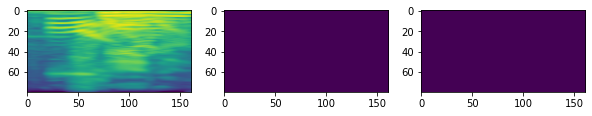

 iteration : 999, loss :            1355482.0

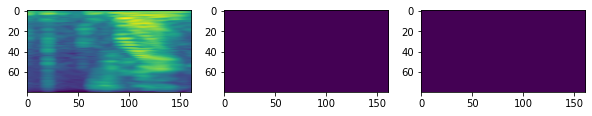

 iteration : 1999, loss :          1365631.125

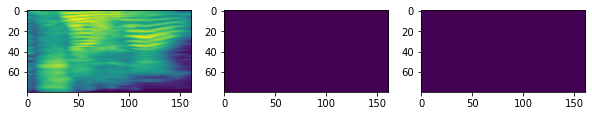

 iteration : 2432, loss :          1473911.625

In [ ]:
trainer.epoch = start_epoch
trainer.iteration = start_iteration
trainer.train()